<a href="https://colab.research.google.com/github/ria-upreti/APS360-project/blob/main/audio_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets # Installing the datasets library

# linking my hugging face account
!huggingface-cli login
#!git config --global credential.helper store

from datasets import load_dataset # Import datasets

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("mozilla-foundation/common_voice_12_0", "da")


"""
sns.set_theme(style = "white", palette = None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])


"""




In [32]:
# youtube tutorial link: https://www.youtube.com/watch?v=ZqpSb5p1xQo&ab_channel=RobMulla
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob # list out files in directory -> reading wave files

import librosa
import librosa.display
import IPython.display as ipd # play files

from itertools import cycle # colours and gimiks
from sklearn.decomposition import PCA

from google.colab import files

In [22]:
#glob('../input/mozilla-foundation/common_voice_12_0')
# Access the 'train' split first, then the element at index 0
len_ds = len(ds["train"]["audio"])

#dsTrain = ds["train"]["audio"]
#print (len_ds)


2734


In [24]:
# define array and sample rate
i = 0
saved_ds = [] # dummy var
y = [] # audioarray
sr = 49000 # standardized sample rate
sr_ds = [] # dummy var
while i < len_ds:
    saved_ds.append(ds["train"][i]["audio"])
    y.append(saved_ds[i]['array'])
    sr_ds.append(saved_ds[i]['sampling_rate'])

    i += 1






In [25]:
# pre processing audio: trimming decibles and length

y_trimmed = [] # dummy var
j = 0
while j < len_ds:
  # trimming decibels
  y_trimmed_audio, _ = librosa.effects.trim(y[j], top_db=25)
  y_trimmed.append(y_trimmed_audio)

  # if audio too long trim down length (avg sr~490000, 3 sec)
  if len(y_trimmed[j]) > 147000:
    y_trimmed[j] = y_trimmed[j][:147000]

  # if audio too short, add padding
  elif len(y_trimmed[j]) < 147000:
    padding = 147000 - len(y_trimmed[j])
    y_trimmed[j] = np.pad(y_trimmed[j], (0, padding), mode='constant')

  j += 1


In [50]:
# test audio
ipd.Audio(data=y_trimmed[0], rate=sr)





In [26]:
# get spectrogram, mel spectrogram and MFCC for all data
i = 0
s_db = [] # spectrogram
melS_db = [] # mel spectrogram
MFCC = [] # MFCC
MFCC_trimmed = [] # MFCC trimmed
n_fft = 2048 # the number of samples per fft
hop_length = 512 # the amount of transform to shift
n_mfcc = 13 # The number of coefficient we extract

while i < len_ds:
    """
    # spectrogram
    s_db.append(librosa.amplitude_to_db(np.abs(y[i]), ref=np.max))
    s_db[i].shape
    s_db_trimmed,_ = librosa.effects.trim(y[i], top_db=35) # trim audio

    # mel spectrogram
    S = librosa.feature.melspectrogram(y=y[i], sr=sr[i], n_mels=128) # dummy
    S[i].shape

    melS_db.append(librosa.amplitude_to_db(S, ref=np.max))
    melS_db[i].shape
    melS_db_trimmed,_ = librosa.effects.trim(y[i], top_db=35) # trim audio
    """

    #Calculate MFCCs for orginal
    mfccs = librosa.feature.mfcc(y=np.abs(y[i]), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    MFCC.append(mfccs) # standardize into 16k hz

    # Calculate MFCCs for the trimmed audio
    mfccs_trimmed = librosa.feature.mfcc(y=np.abs(y_trimmed[i]), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    MFCC_trimmed.append(mfccs_trimmed) # Appending to the list


    i += 1





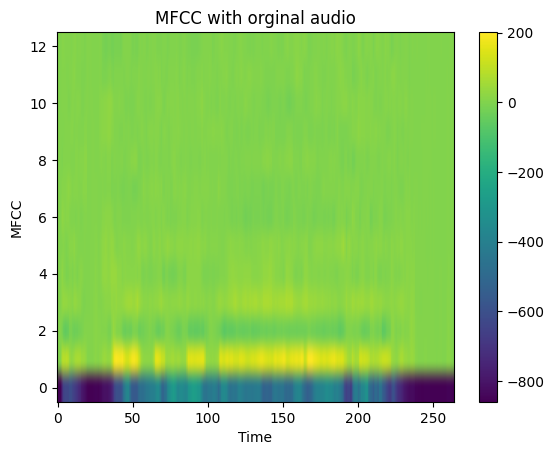

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

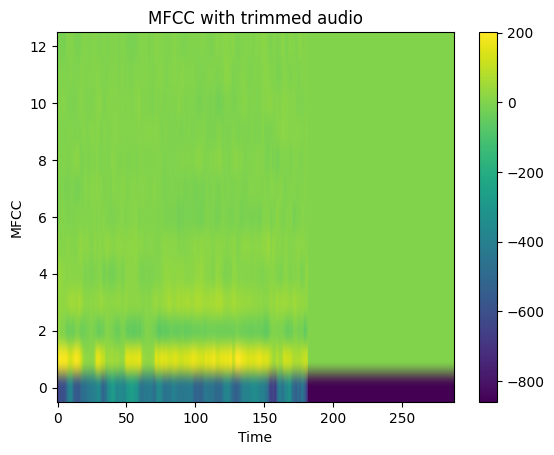

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [35]:
# plot MFCC
plt.imshow(MFCC[0], aspect='auto', origin='lower', cmap='viridis')
plt.title('MFCC with orginal audio')
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar() # Now the colorbar has a plot to reference
plt.show()
plt.savefig('MFCC_orginal.png')
files.download('MFCC_orginal.png')

# plot MFCC trimmed
plt.imshow(MFCC_trimmed[0], aspect='auto', origin='lower', cmap='viridis')
plt.title('MFCC with trimmed audio')
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar() # Now the colorbar has a plot to reference
plt.show()

plt.savefig('MFCC_processed.png')
files.download('MFCC_processed.png')


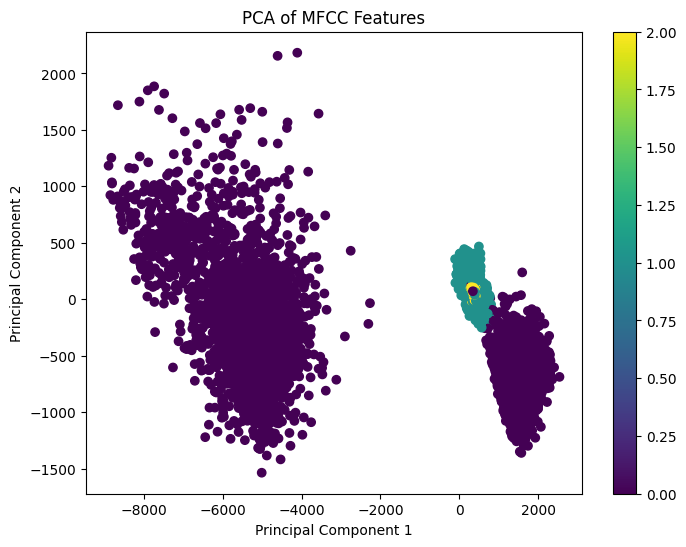

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [34]:
# plotting pca (comparing the processed vs unprocessed data)
# Reshape MFCC data to have consistent dimensions:
num_features = MFCC[0].shape[0]  # Get number of features from the first MFCC
num_time_frames = min(mfcc.shape[1] for mfcc in MFCC)  # Get minimum time frames across all MFCCs

# Resize MFCCs to have consistent time frames
MFCC_resized = [mfcc[:, :num_time_frames] for mfcc in MFCC]
MFCC_trimmed_resized = [mfcc[:, :num_time_frames] for mfcc in MFCC_trimmed]

# Now, stack the MFCCs to create a 2D array
MFCC_data = np.vstack(MFCC_resized)
MFCC_trimmed_data = np.vstack(MFCC_trimmed_resized)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(MFCC_data) # Apply PCA to the reshaped data
X_pca_trimmed = pca.fit_transform(MFCC_trimmed_data) # Apply PCA to the reshaped trimmed data

labels = [0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 0]*(len(X_pca) // 13)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis') # Plot PC1 vs PC2 for original data
plt.colorbar()
plt.title('PCA of MFCC Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
plt.savefig('pca.png')
files.download('pca.png')

This below is my own testing, can ignore

In [ ]:
# playing origionalaudio file
ipd.Audio(data=ds["train"][50]['audio']['array'], rate=ds["train"][0]['audio']['sampling_rate'])

In [ ]:
y = ds0['array'] # array
sr = ds0['sampling_rate'] # sample rate

print(f'y: {y[:10]}')
print(f'shape y:{y.shape}')
print(f'sr:{sr}')

y: [-1.77635684e-14 -2.13162821e-14 -7.10542736e-15 -2.84217094e-14
 -1.33226763e-14  2.13162821e-14  1.77635684e-14  4.97379915e-14
  9.05941988e-14 -3.55271368e-15]
shape y:(381888,)
sr:48000


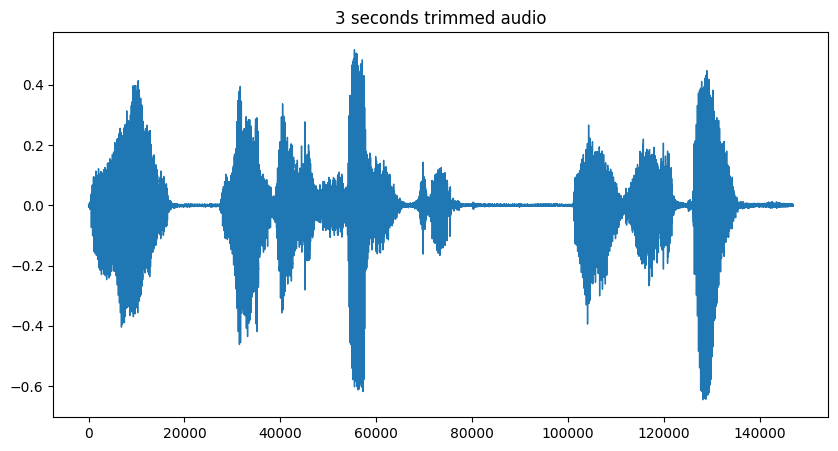

In [57]:
# plot data
pd.Series(y_trimmed[0]).plot(figsize = (10,5), lw = 1, title = "3 seconds trimmed audio")
plt.show()

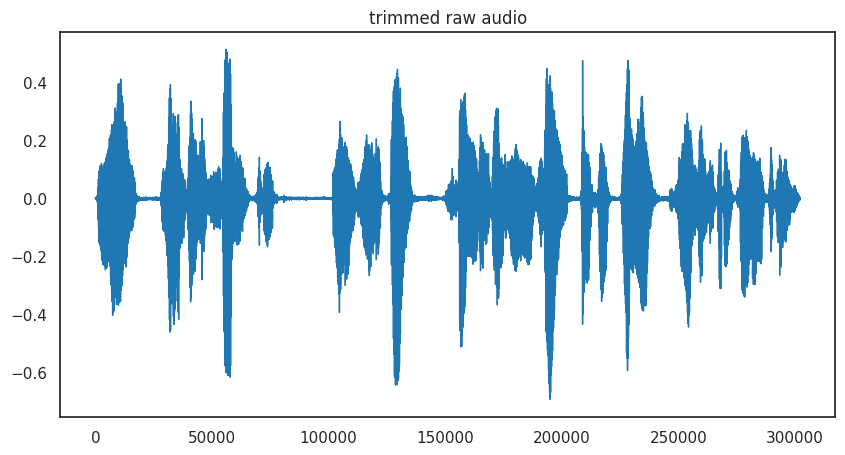

In [ ]:
y_trimmed,_ = librosa.effects.trim(y, top_db=35)
pd.Series(y_trimmed).plot(figsize = (10,5), lw = 1, title = "trimmed raw audio")
plt.show()

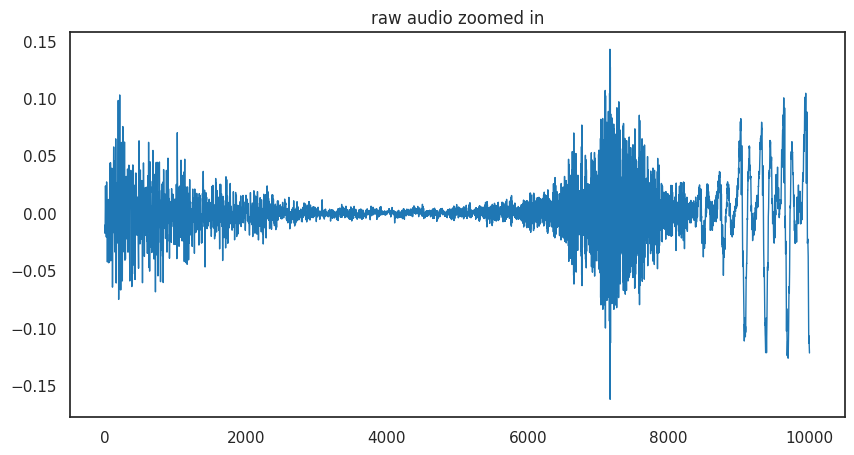

In [ ]:
pd.Series(y[100000:110000]).plot(figsize = (10,5), lw = 1, title = "raw audio zoomed in")
plt.show()

In [37]:
# spectrogram

d = librosa.stft(y[0]) # short time fourier transform

s_db = librosa.amplitude_to_db(np.abs(d), ref=np.max)
s_db.shape




(1025, 746)

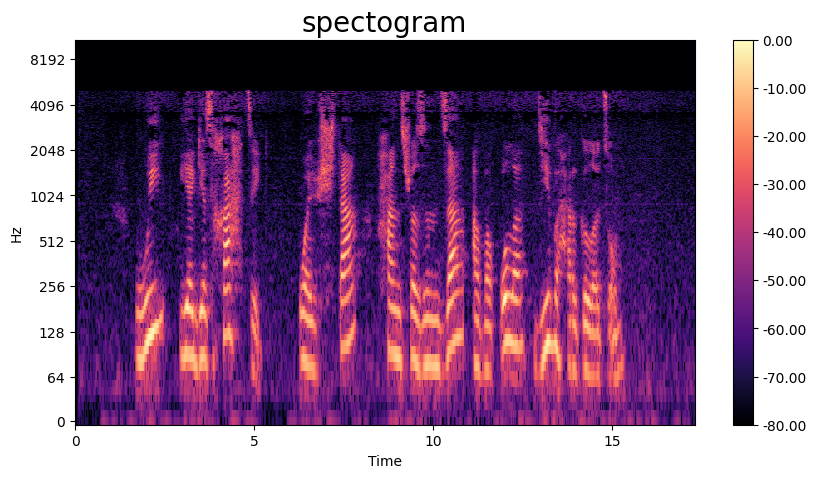

In [38]:
# plot the transformed audio data
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(s_db,
                               x_axis = 'time',
                               y_axis = 'log',
                               ax = ax)
ax.set_title('spectogram', fontsize = 20)
fig.colorbar(img, ax=ax, format=f'%0.2f')

In [ ]:
# melspectogram (melodic)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S.shape

S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
S_db_mel.shape

(128, 746)

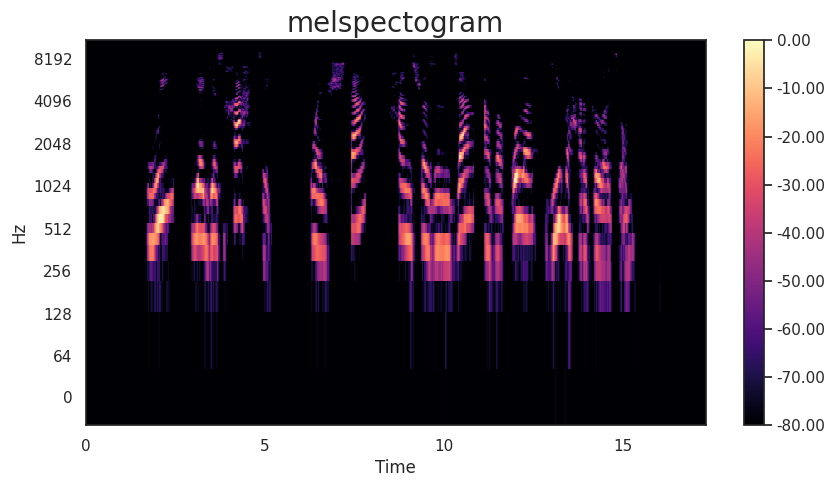

In [ ]:
# plot melspectogram
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_mel,
                               x_axis = 'time',
                               y_axis = 'log',
                               ax = ax)
ax.set_title('melspectogram', fontsize = 20)
fig.colorbar(img, ax=ax, format=f'%0.2f')

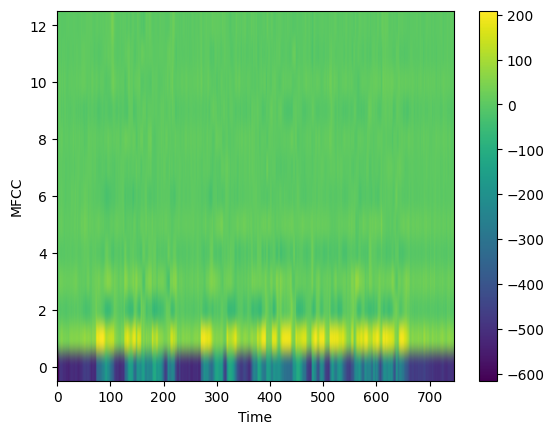

In [7]:
# get MFCC

"""
tutorial link: https://www.youtube.com/watch?v=Oa_d-zaUti8&ab_channel=ValerioVelardo-TheSoundofAI
signal is the input
n_fft is the number of samples per fft
hop length is the amount of transform to shift
n_nfcc is the number of coefficient we extract

n_fft = 2048
hop_length = 512
stft = librosa.stft(signal, n_fft, hop_length = hop_length)

specgrogram = np.abs(stft)
specgrogram.shape

log_specgrogram = librosa.amplitude_to_db(specgrogram)
log_specgrogram.shape


MFCC = librosa.feature.mfcc(signal, n_fft, hop_length = hop_length, n_nfcc = 13)
"""
MFCC_test = librosa.feature.mfcc(y=np.abs(y[0]), sr=sr[0], n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
plt.imshow(MFCC_test, aspect='auto', origin='lower', cmap='viridis')

plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar() # Now the colorbar has a plot to reference
plt.show()
